In [12]:
import os
import arviz as az
import corner
import pandas as pd
import exoplanet as xo
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx

In [2]:
ground_truth = {
    "period": 3.5,
    "t0": 1.3,
    "us": [0.5, 0.2],
    "r": 0.03,
    "a": 10,
    "yerr": 1e-4
}

In [3]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [4]:
t = np.arange(0, 20, 2/60/24)

In [6]:
with pm.Model() as model:
    # evaluate period in log-space
    logP = pm.Normal("logP", mu=np.log(ground_truth["period"]), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # wide prior on t0 to try and help latch onto truth
    t0 = pm.Normal("t0", sd=10, testval=ground_truth["t0"])

    # Kipping (2013) parameterization
    us = xo.distributions.QuadLimbDark("us", testval=ground_truth["us"])

    r = pm.Uniform("r", lower=0.01, upper=0.1, testval=ground_truth["r"])

    # evaluate a in log-space
    loga = pm.Normal("loga", mu=np.log(ground_truth["a"]), sd=0.1)
    a = pm.Deterministic("a", pm.math.exp(loga))

    # create orbit
    # parameterization is largely correlation-free
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, a=a)

    # evaluate light curve, with mean flux of 1
    y = xo.LimbDarkLightCurve(us).get_light_curve(orbit=orbit, r=r, t=t)[:, 0]
    y += 1
    pm.Deterministic("y", y)

    # for error model use basic half-cauchy
    yerr = pm.HalfCauchy("yerr", 0.1, testval=ground_truth["yerr"])

    # ONLY HERE: create data
    flux = pmx.eval_in_model(y) + ground_truth["yerr"] * np.random.randn(len(t))

    # Guassian likelihood
    pm.Normal("obs", mu=y, sd=yerr, observed=flux)

In [24]:
# save data
np.savez(datadir(f"generated_data_{ground_truth['yerr']*1e6:.0f}ppm.npz"), t=t, flux=flux)

In [8]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [yerr, loga, r, us, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 112223.99579941804 -> 112226.90625275609


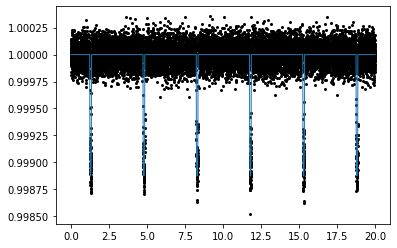

In [10]:
import matplotlib.pyplot as plt
plt.plot(t, flux, ".k", ms=4, label="data")
plt.plot(t, map_soln["y"], lw=1)

In [11]:
np.random.seed(8462852)
with model:
    trace = pmx.sample(
        tune=5000,
        draws=5000,
        start=map_soln,
        cores=4,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [yerr, loga, r, us, t0, logP]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 147 seconds.


In [13]:
trace.to_netcdf(datadir("exoplanet+NUTS_trace.nc"))
# make sure loads
trace = az.InferenceData.from_netcdf(datadir("exoplanet+NUTS_trace.nc"))

In [14]:
var_names = ["period", "t0", "r", "a", "us", "yerr"]
with model:
    summary = az.summary(trace, var_names=var_names)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,3.500,0.000,3.500,3.500,0.000,0.000,31537.0,15212.0,1.0
t0,1.300,0.000,1.300,1.300,0.000,0.000,30652.0,15386.0,1.0
r,0.030,0.000,0.030,0.030,0.000,0.000,26388.0,14977.0,1.0
a,10.023,0.030,9.966,10.080,0.000,0.000,21052.0,14170.0,1.0
us[0],0.552,0.062,0.439,0.673,0.000,0.000,20256.0,10206.0,1.0
us[1],0.048,0.109,-0.157,0.252,0.001,0.001,17858.0,10181.0,1.0
yerr,0.000,0.000,0.000,0.000,0.000,0.000,30686.0,15794.0,1.0


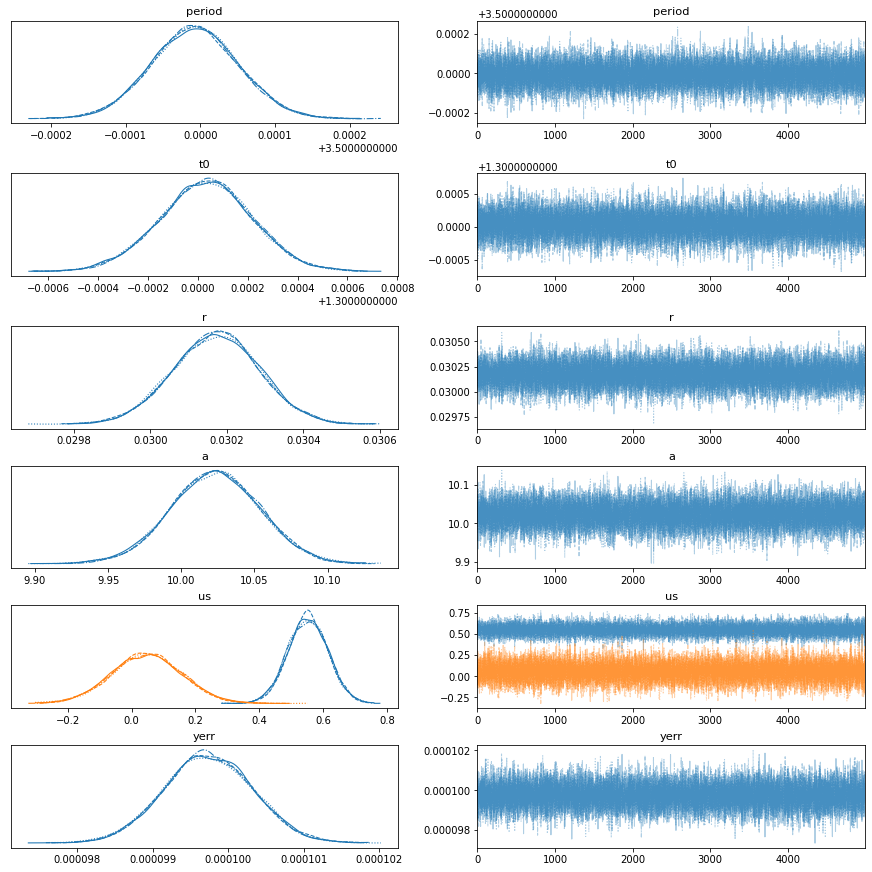

In [15]:
with model:
    az.plot_trace(trace, var_names=var_names);

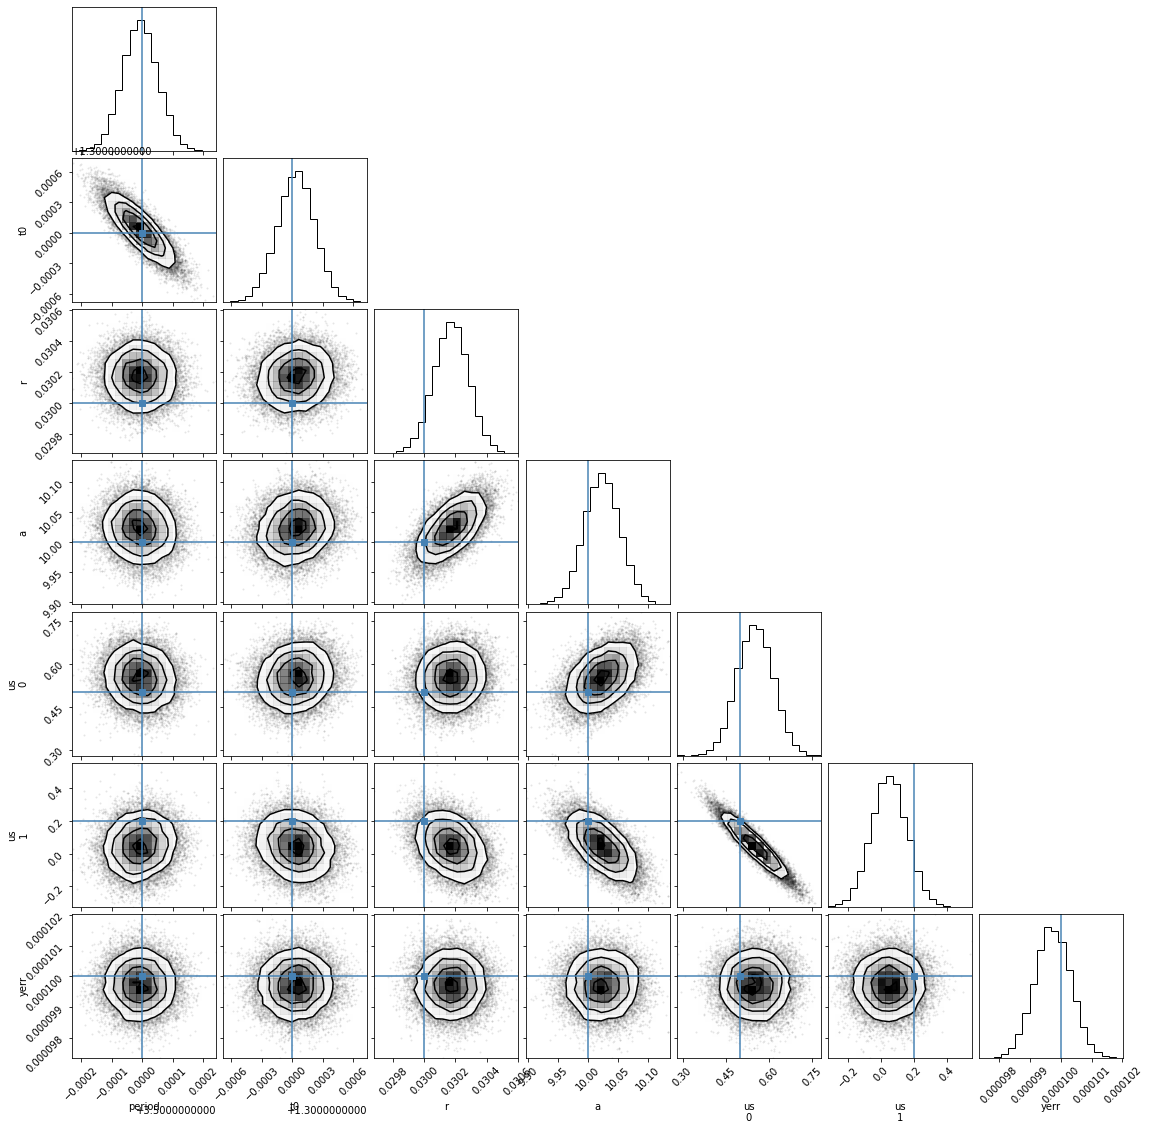

In [16]:
truth = dict(
    zip(
        var_names,
        xo.eval_in_model([period, t0, r, a, us, yerr], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=var_names,
    truths=truth,
)

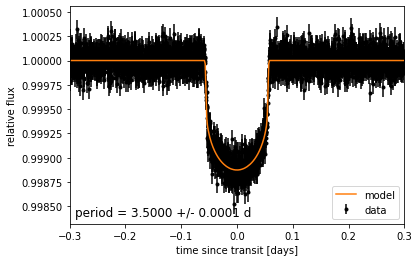

In [18]:
# Get the posterior median orbital parameters
p = np.median(trace["posterior"]["period"])
t0 = np.median(trace["posterior"]["t0"])

# Plot the folded data
x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.errorbar(
    x_fold, flux, yerr=ground_truth["yerr"], fmt=".k", label="data", zorder=-1000
)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["posterior"]["y"]
pred = np.median(pred, axis=(0, 1))
plt.plot(x_fold[inds], pred[inds], color="C1", label="model")

# Annotate the plot with the planet's period
Pmean = np.mean(trace["posterior"]["period"]).values
Pstd = np.std(trace["posterior"]["period"]).values
txt = f"period = {Pmean:.4f} +/- {Pstd:.4f} d"
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.xlim(-0.3, 0.3);